##  Calibrating the Amplitude of a Single Qubit Gate

NOTE: Needs the terra PR to fix the zero pulse width

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime, pickle

#Import Qiskit classes classes
import qiskit
#from qiskit.providers.aer.noise import NoiseModel
#from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
import random
from qiskit.test.mock import FakeOpenPulse2Q

#import the ignis characterization routine
import qiskit.ignis.characterization.gates as char
import qiskit.ignis.calibrations as calib
import qiskit.ignis.characterization.coherence as coh
#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Flag to calibrate the simulator
#otherwise will calibrate the pulses from Pok
use_simulator = False

#define which parts to calibrate together
cal_subsets = [[0, 2, 4, 6, 8, 10, 12, 14, 16, 18],
              [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]]

cal_subsets = [[0], [1]]

#define which cals to run
run_freq_cal = True

In [2]:
#Get a pulse configuration from the fake backend
if use_simulator:
    backend_real = FakeOpenPulse2Q()
    #Get pulse simulator backend
    backend_sim = qiskit.Aer.get_backend('pulse_simulator')
else:
    qiskit.IBMQ.load_account()
    provider = qiskit.IBMQ.get_provider(project='asplos')
    backend_real = provider.get_backend('ibmq_singapore')

In [3]:
back_config = backend_real.configuration().to_dict()
back_defaults = backend_real.defaults()
system = pulse.PulseChannelSpec.from_backend(backend_real)
cmd_def = pulse.CmdDef.from_defaults(back_defaults.cmd_def,back_defaults.pulse_library)

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:354: UserWarning: The time delta is now returned in units of [s] rather than [ns].
  warnings.warn("The time delta is now returned in units of [s] rather than [ns].")
/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:348: UserWarning: The time delta is now returned in units of [s] rather than [ns].
  warnings.warn("The time delta is now returned in units of [s] rather than [ns].")


In [4]:
f_qubits = [e for e in back_defaults.qubit_freq_est]

In [5]:
#fit the pulses from the cmd_def to build a drag pulse dictionary
if not use_simulator:
    single_q_params = calib.get_single_q_pulse(cmd_def, qubits=range(back_config['n_qubits']))
    #set all the drag's to zero and use a common sigma
    sigma_ratio = np.round(single_q_params[0]['duration']/single_q_params[0]['sigma'])
    for q_params in single_q_params:
        #q_params['beta'] = 0
        q_params['sigma'] = q_params['duration']/sigma_ratio
    f_qubits = [e for e in back_defaults.qubit_freq_est]
else:
    single_q_params = [{'duration': 128, 'sigma': 128/4, 'amp': 0.4, 'beta': 0} for e in range(2)]
    f_qubits = [0 for e in range(2)]

### Design the Hamiltonian (Simulator Only)

If we're using the simulator we need to build a transmon Hamiltonian with anharmonicity to test the Rabi oscillation and CR

In [6]:
hamiltonian = {}
hamiltonian['h_str'] = []
#Q0 terms
hamiltonian['h_str'].append('np.pi*(2*v0-alpha0)*O0')
hamiltonian['h_str'].append('np.pi*alpha0*O0*O0')
hamiltonian['h_str'].append('2*np.pi*r*X0||D0')
hamiltonian['h_str'].append('2*np.pi*r*X0||U1')
hamiltonian['h_str'].append('2*np.pi*r*X1||U0')

#Q1 terms
hamiltonian['h_str'].append('np.pi*(2*v1-alpha1)*O1')
hamiltonian['h_str'].append('np.pi*alpha1*O1*O1')
hamiltonian['h_str'].append('2*np.pi*r2*X1||D1')

#Exchange coupling betwene Q0 and Q1
hamiltonian['h_str'].append('2*np.pi*j*(Sp0*Sm1+Sm0*Sp1)')
hamiltonian['vars'] =  {'v0': 5.00, 'v1': 5.1, 'j': 0.01, 
                        'r': 0.02, 'r2': 0.015, 'alpha0': -0.33, 'alpha1': -0.33}

#set the qubit dimensions to 3
hamiltonian['qub'] = {'0': 3, '1': 3}

if use_simulator:
    #update the back_end
    back_config['hamiltonian'] = hamiltonian
    back_config['noise'] = {}
    back_config['dt'] = 1.0

    #add solver settings
    back_config['ode_options'] = {}

    #add qubit whitelist
    back_config['qubit_list'] = [0,1]

<a id='rabi'></a>
# Rough Cal (Rabi Oscillation)

Vary the amplitude of a Gaussian pulse to find the pi and pi/2 amplitudes. This happens on ALL qubits for the device

In [7]:
exps = 41
shots = 512
max_amp = 0
for g_param in single_q_params:
    if g_param['amp']>max_amp:
        max_amp=g_param['amp']
print(max_amp)
max_rabi_amp = np.min([0.99, 2.5*max_amp])
        
drive_amps = np.linspace(-max_rabi_amp, max_rabi_amp, exps)
rabi_scheds, xdata = calib.rabi_schedules(drive_amps, range(len(single_q_params)), 
                                          single_q_params[0]['duration'], 
                                          pulse_sigma = single_q_params[0]['sigma'],
                                          system=system, cmd_def=cmd_def, 
                                      meas_map=backend_real.configuration().meas_map)

0.28191405515019413


In [8]:
if use_simulator:
    
    #need to assemble twice to get the eigenvalues
    
    rabi_qobj = assemble(rabi_scheds, backend_real, 
                         meas_level=1, meas_return='avg', 
                         memory_slots=2,
                         shots=shots, sim_config = back_config)
    
    evals, estates = backend_sim.get_dressed_energies(rabi_qobj)
    
    rabi_qobj = assemble(rabi_scheds, backend_real, 
                     meas_level=1, meas_return='avg', 
                     memory_slots=2, qubit_lo_freq = [evals[1]/2/np.pi,
                                                      evals[3]/2/np.pi],
                     shots=shots, sim_config = back_config)
else:
    rabi_qobj = assemble(rabi_scheds, backend_real, 
                         meas_level=1, meas_return='avg', 
                         memory_slots=2,
                         shots=shots, qubit_lo_freq = f_qubits)

In [9]:
#Note: this is how to run bypassing the backend
#opsys = qiskit.providers.aer.openpulse.qobj.digest.digest_pulse_obj(rabi_qobj.to_dict())
#simdata = qiskit.providers.aer.openpulse.solver.opsolve.opsolve(opsys)

In [10]:
if use_simulator:
    rabi_job = backend_sim.run(rabi_qobj)
else:
    rabi_job = backend_real.run(rabi_qobj)

In [23]:
rabi_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [24]:
rabi_result = rabi_job.result()

In [25]:
rabifit = calib.RabiFitter(rabi_result, xdata, range(len(single_q_params)), 
                           fit_p0 = [2.0e15, 2, 0, 0])

for i in range(len(single_q_params)):
    
    #refit the data
    rabifit.fit_data(qid=i, p0=rabifit.guess_params(i))

/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Pi Amp: 0.311840
Pi Amp: 0.353163
Pi Amp: 0.291425
Pi Amp: 0.410677


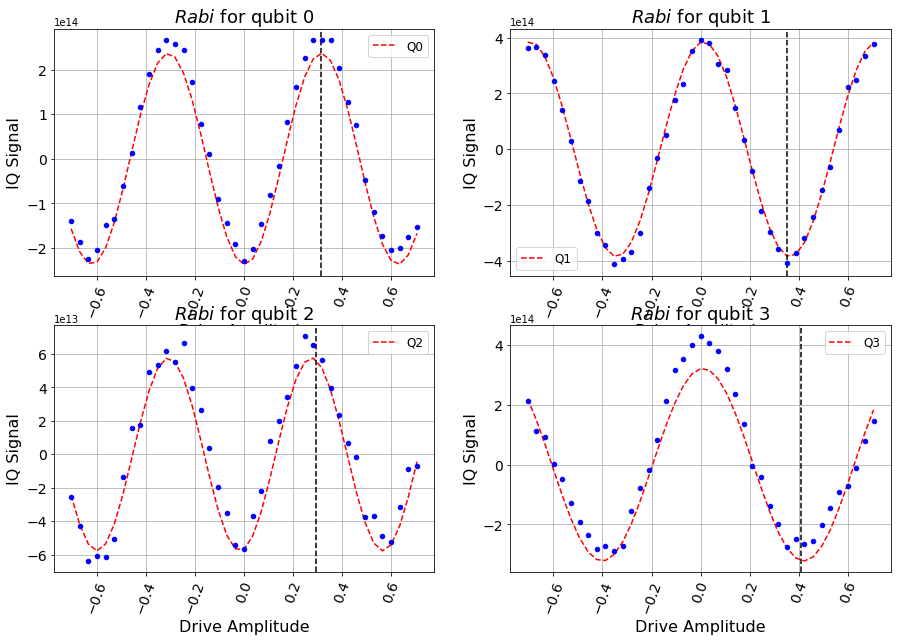

In [105]:
plt.figure(figsize=(15, 10))
q_offset = 0
for i in range(min([len(single_q_params), 4])):
    
    ax = plt.subplot(2, 2, i+1)
    rabifit.plot(i+q_offset, ax=ax)
    print('Pi Amp: %f'%rabifit.piamp(i+q_offset))
plt.show()

In [27]:
#Update the device parameters and cmd def
for i in range(len(single_q_params)):
    single_q_params[i]['amp'] = rabifit.pi2amp(i)
    
calib.update_u_gates(single_q_params, qubits=range(len(single_q_params)), cmd_def=cmd_def, system=system)


# Frequency Cal

The frequencies from the backend should be good. Run this if you're not sure. Will run on the `cal_subsets` defined in the beginning and will update the frequencies used for subsequent runs.

In [ ]:
n_max_iters = 1

cal_fits = [[[] for i in range(n_max_iters)] for e in range(len(cal_subsets))]

#NOTE: This works with the most up to date terra, otherwise you need to multiply the line
#below by 1e-9
gate_time = cmd_def.get('id', qubits=[0]).duration*back_config['dt']
print(gate_time)

if not run_freq_cal:
    print("Skipping the frequency calibration")

for j in range(len(cal_subsets)*run_freq_cal):
    
    for i in range(n_max_iters):

        
        #make the circuits
        t2circs, xdata, osc = coh.t2star_circuits(np.array(range(10,201,10)), 
                                                  gate_time=gate_time, qubits=cal_subsets[j], nosc=5)
        t2circs = qiskit.transpile(t2circs, backend_real, optimization_level=1)
        
        #convert qasm->pulse
        schedule_config = qiskit.scheduler.ScheduleConfig(cmd_def, meas_map=backend_real.configuration().meas_map)
        t2_cal_sch = [qiskit.scheduler.schedule_circuit(t2circ, schedule_config) for t2circ in t2circs]
        #make the qobj

        #run 
        print('Running Subset %d, Iteration %d'%(j,i))
        if use_simulator:
            t2_cal_qobj = assemble(t2_cal_sch, backend_real, 
                     meas_level=2,
                     memory_slots=2, qubit_lo_freq = [evals[1]/2/np.pi,
                                                      evals[3]/2/np.pi],
                     shots=1024, sim_config = back_config)
            fcal_result = backend_sim.run(t2_cal_qobj).result()
        else:
            t2_cal_qobj = assemble(t2_cal_sch, backend_real, 
                     meas_level=2,
                     shots=1024, qubit_lo_freq = f_qubits)
            fcal_result = backend_real.run(t2_cal_qobj).result()

        #Fit the data
        cal_fits[j][i] = coh.T2StarFitter(None, xdata, qubits=range(len(single_q_params)), 
                            fit_p0 = [0,0,0,0,0], fit_bounds=None)
        
        cal_fits[j][i].add_data(fcal_result, refit=False)
        
        #get the pi amplitude
        f_errs =  np.zeros(len(single_q_params))
        for ii in cal_subsets[j]:
            cal_fits[j][i].fit_data(ii, p0=cal_fits[j][i].guess_params(ii))
            f_errs[ii] = cal_fits[j][i].params['0'][ii][2]-osc
            print('Freq Error Q%d: %f'%(ii, f_errs[ii]))
            #update the qubit_freqs
            f_qubits[ii] += f_errs[ii]/1e9
            
        if max(np.abs(f_errs))<5e3:
            print('No more iterations needed')
            break
            

# DRAG Cal

This does a rough drag cal on ALL qubits of the device

In [28]:
amp_list = [e['amp'] for e in single_q_params]

drag_scheds, xdata = calib.drag_schedules(np.linspace(-3,3,41), range(len(single_q_params)), 
                                          amp_list,
                                          single_q_params[0]['duration'], 
                                          pulse_sigma = single_q_params[0]['sigma'],
                                          system=system, cmd_def=cmd_def, 
                                      meas_map=backend_real.configuration().meas_map)

In [29]:
if use_simulator:
    drag_qobj = assemble(darg_scheds, backend_real, 
                     meas_level=1, meas_return='avg', 
                     memory_slots=2, qubit_lo_freq = [evals[1]/2/np.pi,
                                                      evals[3]/2/np.pi],
                     shots=shots, sim_config = back_config)
else:
    drag_qobj = assemble(drag_scheds, backend_real, 
                         meas_level=1, meas_return='avg',
                         shots=shots, qubit_lo_freq = f_qubits)

In [30]:
if use_simulator:
    drag_job = backend_sim.run(drag_qobj)
else:
    drag_job = backend_real.run(drag_qobj)

In [31]:
drag_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [32]:
drag_result = drag_job.result()

In [33]:
dragfit = calib.DragFitter(drag_result, xdata, range(len(single_q_params)), 
                           fit_p0 = [2.0e7, 0, 0])

for i in range(len(single_q_params)):
    
    #refit the data
    dragfit.fit_data(qid=i, p0=dragfit.guess_params(i), bounds=[(-np.inf, xdata[0], -np.inf), 
                                                                (np.inf, xdata[-1], np.inf)])
    

/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Drag Amp: -0.395785
Drag Amp: -1.106406
Drag Amp: -3.000000
Drag Amp: -0.609100


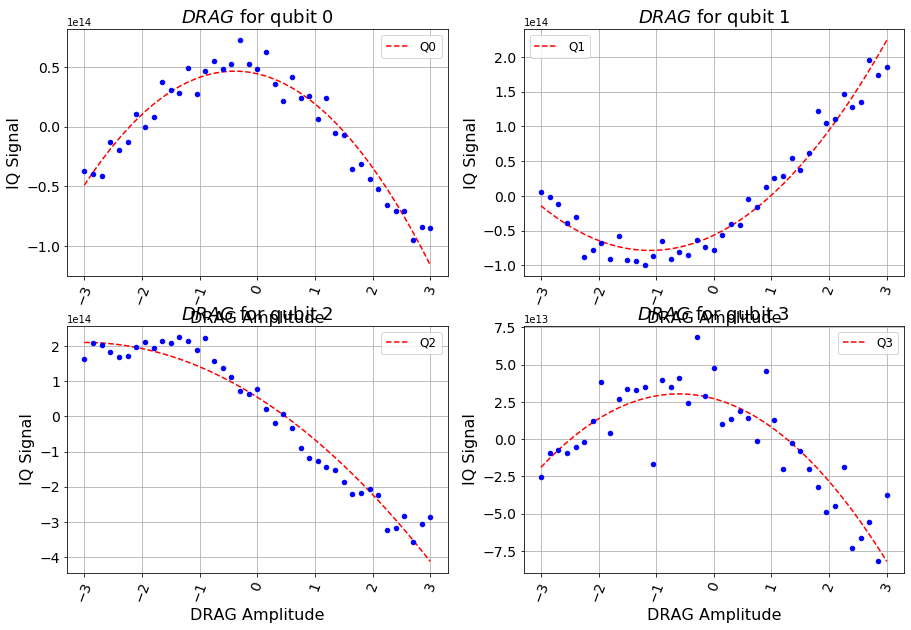

In [34]:
plt.figure(figsize=(15, 10))
q_offset = 0
for i in range(min([len(single_q_params), 4])):
    
    ax = plt.subplot(2, 2, i+1)
    dragfit.plot(i+q_offset, ax=ax)
    print('Drag Amp: %f'%dragfit.dragamp(i+q_offset))
plt.show()

In [109]:
#Update the device parameters and update the cmd def
for i in range(len(single_q_params)):
    single_q_params[i]['beta'] = dragfit.dragamp(i)

calib.update_u_gates(single_q_params, qubits=cal_subsets[j], cmd_def=cmd_def, system=system)

<a id='readout_test'></a>
# Fine Cal - Ignis Amplitude Amplification

Using the pulse calibrated above, feed that into the calibration routine for a fine amplitude calibration

In [36]:
(single_q_params[0]['amp']-0.17)/0.15

-0.09386623508689573

In [37]:
n_max_iter = 2

cal_fits = [[[] for i in range(n_max_iter)] for e in range(len(cal_subsets))]

for j in range(len(cal_subsets)):
    
    for i in range(n_max_iter):

        #Note: takes about 20-30s

        #Update the pi/2 amplitude
        if i != 0:
            for ii in cal_subsets[j]:
                single_q_params[ii]['amp'] /= (1+2*amp_errs[ii]/(np.pi/2))
                print('Pi2 Amp: %f'%single_q_params[ii]['amp'])


        calib.update_u_gates(single_q_params, qubits=cal_subsets[j], cmd_def=cmd_def, system=system)


        #make the circuits
        amp_cal_circs, xdata = char.ampcal_1Q_circuits(9,qubits=cal_subsets[j])

        #convert qasm->pulse
        schedule_config = qiskit.scheduler.ScheduleConfig(cmd_def, meas_map=backend_real.configuration().meas_map)
        amp_cal_sch = [qiskit.scheduler.schedule_circuit(ampcirc, schedule_config) for ampcirc in amp_cal_circs]

        #make the qobj



        #run 
        print('Running Subset %d, Iteration %d'%(j,i))
        if use_simulator:
            amp_cal_qobj = assemble(amp_cal_sch, backend_real, 
                     meas_level=2,
                     memory_slots=2, qubit_lo_freq = [evals[1]/2/np.pi,
                                                      evals[3]/2/np.pi],
                     shots=1024, sim_config = back_config)
            ampcal_result = backend_sim.run(amp_cal_qobj).result()
        else:
            amp_cal_qobj = assemble(amp_cal_sch, backend_real, 
                     meas_level=2,
                     shots=1024, qubit_lo_freq = f_qubits)
            ampcal_result = backend_real.run(amp_cal_qobj).result()

        #Fit the data
        cal_fits[j][i] = char.AmpCalFitter(None, xdata, qubits=range(len(single_q_params)), fit_p0=[0, 0],
                       fit_bounds=([-np.pi, -1],
                                   [np.pi, 1]))
        
        cal_fits[j][i].add_data(ampcal_result, refit=False)

        #get the pi amplitude
        amp_errs = np.zeros(len(single_q_params))
        for ii in cal_subsets[j]:
            cal_fits[j][i].fit_data(ii)
            amp_errs[ii] = cal_fits[j][i].angle_err(ii)
            print('Angle Error Q%d: %f'%(ii, amp_errs[ii]))
            
        if np.max(np.abs(amp_errs))<3e-3:
            print('Amplitude calibrated, no more iterations needs')
            break

Running Subset 0, Iteration 0
Angle Error Q0: 0.077600
Pi2 Amp: 0.141900
Running Subset 0, Iteration 1
Angle Error Q0: -0.002319
Amplitude calibrated, no more iterations needs
Running Subset 1, Iteration 0
Angle Error Q1: 0.038909
Pi2 Amp: 0.168247
Running Subset 1, Iteration 1
Angle Error Q1: 0.018858


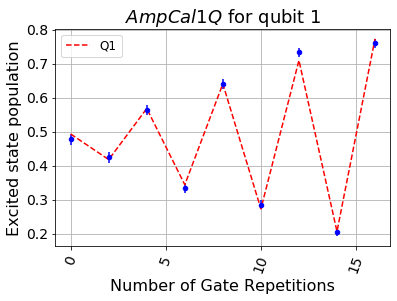

In [39]:
%matplotlib inline
cal_fits[1][1].plot(1)

# Save the Command Def and Frequencies

Save the calibrated command def and the list of frequencies for use later. Doesn't work right now to save the whole command def, but can save the pulse dictionary.

In [42]:
datestr = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M')
filestr = 'PULSE_%s_%s'%(backend_real.name(), datestr)
filestr2 = 'FQ_%s_%s'%(backend_real.name(), datestr)
f0 = open(filestr, 'wb')
#pickle.dump(cmd_def, f0)
pickle.dump(single_q_params, f0)
f0.close()
f0 = open(filestr2, 'wb')
pickle.dump(f_qubits, f0)
f0.close()

## See improvement with cal

In [112]:
u0 = cmd_def.get('u3', (0), np.pi, 0, np.pi)  # calibrated
x0 = cmd_def.get('x', (0), np.pi, 0, np.pi)   # non-calibrated
measure = cmd_def.get('measure', tuple(range(0, 20)))

sched0 = u0
sched0 += measure << sched0.duration+5

sched1 = x0
sched1 += measure << sched1.duration+5

In [113]:
from qiskit import execute
from qiskit.ignis.verification.tomography.data import marginal_counts
x_job = execute([sched0, sched1], backend_real, shots=1000)
result = x_job.result()
print("u3(pi,0,pi) gate: ", marginal_counts(result.get_counts(0), [0]))
print("x gate:", marginal_counts(result.get_counts(1), [0]))

u3(pi,0,pi) gate:  {'0': 50, '1': 950}
x gate: {'0': 143, '1': 857}
